0. Saving concatenated parquet files into DataFrame

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

concatenatedfile_path=os.path.join("..", "data", "processed","concatenated_data")
image_dir = os.path.join("..", "reports","figures", "plot_image")

event=pd.read_parquet(f'{concatenatedfile_path}/event_concatenated.parquet')
away_team=pd.read_parquet(f'{concatenatedfile_path}/away_team_concatenated.parquet')
away_team_score=pd.read_parquet(f'{concatenatedfile_path}/away_team_score_concatenated.parquet')
home_team=pd.read_parquet(f'{concatenatedfile_path}/home_team_concatenated.parquet')
home_team_score=pd.read_parquet(f'{concatenatedfile_path}/home_team_score_concatenated.parquet')
odds=pd.read_parquet(f'{concatenatedfile_path}/odds_concatenated.parquet')
pbp=pd.read_parquet(f'{concatenatedfile_path}/pbp_concatenated.parquet')
power=pd.read_parquet(f'{concatenatedfile_path}/power_concatenated.parquet')
round=pd.read_parquet(f'{concatenatedfile_path}/round_concatenated.parquet')
season=pd.read_parquet(f'{concatenatedfile_path}/season_concatenated.parquet')
statistics=pd.read_parquet(f'{concatenatedfile_path}/statistics_concatenated.parquet')
time=pd.read_parquet(f'{concatenatedfile_path}/time_concatenated.parquet')
tournament=pd.read_parquet(f'{concatenatedfile_path}/tournament_concatenated.parquet')
venue=pd.read_parquet(f'{concatenatedfile_path}/venue_concatenated.parquet')
votes=pd.read_parquet(f'{concatenatedfile_path}/votes_concatenated.parquet')


0. Function to determine winner code of each match based on point by point records

In [2]:
def determine_winner_code_basedon_pbp():
    unique_matchids = pd.Series(pbp['match_id'].unique())
    results = []
    
    # Iterate over each unique match ID
    for match in unique_matchids:
        my_match = pbp[pbp['match_id'] == match]
        max_home_score = my_match['home_score'].max()
        max_away_score= my_match['away_score'].max()
        if max_home_score > max_away_score:
            winner = 'home'  # Home team wins
        else:
            winner = 'away'  # Away team wins

        # Append the match ID and winner to the results list
        results.append({'match_id': match, 'winner': winner})

    # Create a DataFrame from the results list
    winner_df = pd.DataFrame(results)
    return winner_df

winnercode_df=determine_winner_code_basedon_pbp()

1. How many tennis players are included in the dataset?

In [3]:
# Extract player_id columns
home_player_ids = home_team['player_id']
away_player_ids = away_team['player_id']

# Combine and count unique player_ids
all_player_ids = pd.concat([home_player_ids, away_player_ids])
unique_player_ids = all_player_ids.nunique()
print(f'The number of unique tennis players in the dataset is: {unique_player_ids}')

The number of unique tennis players in the dataset is: 2352


2. What is the average height of the players?

In [4]:
# Extract height columns
home_team_height=home_team[['player_id','height','Record_date']]
away_team_height=away_team[['player_id','height','Record_date']]

# Combine and count unique player_id and height
all_heights=pd.concat([home_team_height,away_team_height]).sort_values('Record_date').drop_duplicates(['player_id'],keep='last').dropna()

average_height=all_heights['height'].mean()
# average_height will be formatted with two decimal places
print(f'The average height of the players is: {average_height:.2f}')

The average height of the players is: 1.82


3. Which player has the highest number of wins?

In [5]:
# Merge winnerCode with home/away team to find player id and name of the winner
home_winners = winnercode_df[winnercode_df['winner'] == 'home'].merge(home_team[['match_id','player_id','full_name']], on='match_id', how='inner').drop_duplicates()
away_winners = winnercode_df[winnercode_df['winner'] == 'away'].merge(away_team[['match_id','player_id','full_name']], on='match_id', how='inner').drop_duplicates()

all_winners=pd.concat([home_winners,away_winners])

# Count the number of wins for each player
win_counts = all_winners.groupby(['player_id', 'full_name']).size().reset_index(name='count')

# Find the player with the highest number of wins
top_player = win_counts.loc[win_counts['count'].idxmax()]
print(f'Player with the highest number of wins is : {top_player["full_name"]} (player ID : {top_player["player_id"]}) with {top_player["count"]} wins')

Player with the highest number of wins is : Sun, Fajing (player ID : 163438) with 15 wins


4. What is the longest match recorded in terms of duration?

In [6]:
time['total_duration'] = time[['period_1', 'period_2', 'period_3', 'period_4', 'period_5']].sum(axis=1, skipna=True)
last_time_per_match=time.sort_values('Record_date').drop_duplicates(['match_id'],keep='last')

# Find the match with the longest duration
longest_match = last_time_per_match.loc[last_time_per_match['total_duration'].idxmax()]
print(f'The match with the ID : {longest_match["match_id"]} has the longest duration, which is : {longest_match["total_duration"]/3600} hours.')

The match with the ID : 12346747 has the longest duration, which is : 47.5425 hours.


5. How many sets are typically played in a tennis match?

The typical number of sets played in the tennis match of dataset is 2 sets.


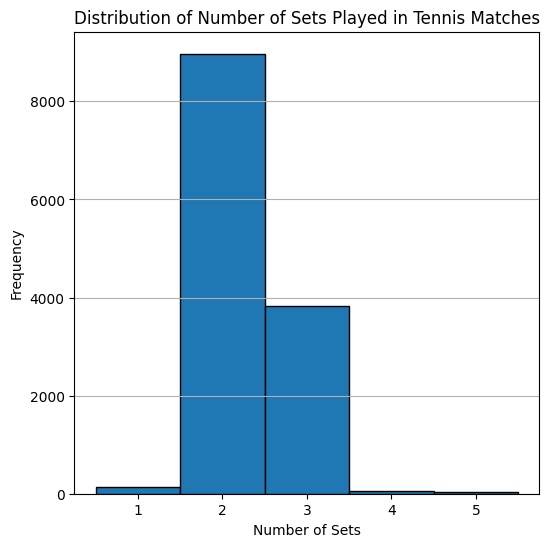

In [7]:
# Calculate the number of sets played in each match
time['num_sets'] = time[['period_1', 'period_2', 'period_3', 'period_4', 'period_5']].notnull().sum(axis=1)
last_time_per_match=time.sort_values('Record_date').drop_duplicates(['match_id'],keep='last')

# Find the most common number of sets played (mode)
typical_num_sets = last_time_per_match['num_sets'].mode()[0]
print(f"The typical number of sets played in the tennis match of dataset is {typical_num_sets} sets.")


# Plotting the histogram
plt.figure(figsize=(6, 6))
plt.hist(time['num_sets'], bins=range(1, 7), edgecolor='black', align='left')
plt.xlabel('Number of Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Sets Played in Tennis Matches')
plt.xticks(range(1, 6))
plt.grid(axis='y')
save_path = os.path.join(image_dir, '5.jpg')
plt.savefig(save_path)
plt.show()

6. Which country has produced the most successful tennis players?

The country with the most successful tennis players is: USA with success_metric : 486 including 462 count of winner in may 2024 and 24 count of top 100 players


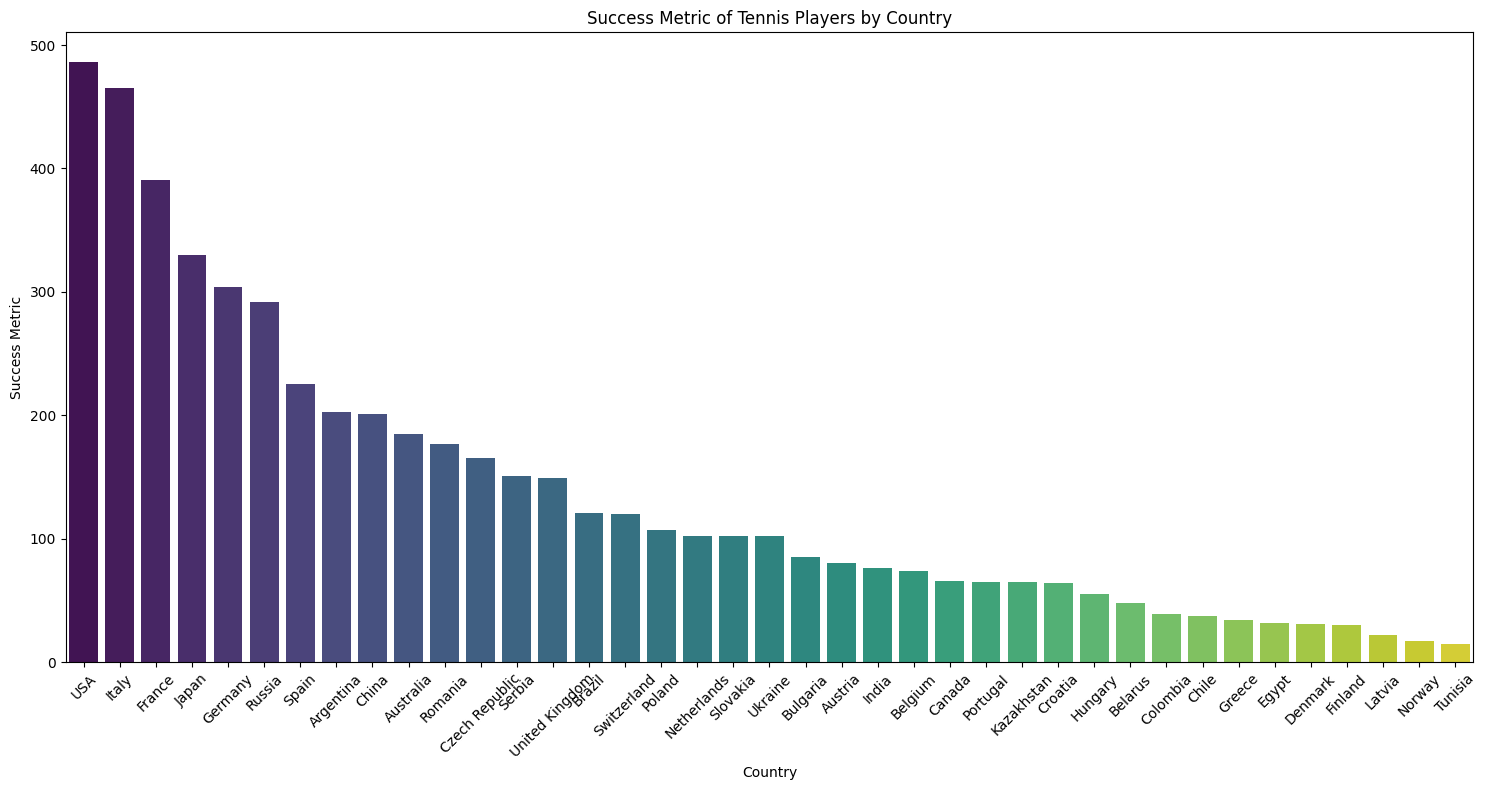

In [100]:
# Merge winnerCode with home/away team to find player id and country of the winner
home_winners_country = winnercode_df[winnercode_df['winner'] == 'home'].merge(home_team[['match_id','player_id','country']], on='match_id', how='inner').drop_duplicates()
away_winners_country = winnercode_df[winnercode_df['winner'] == 'away'].merge(away_team[['match_id','player_id','country']], on='match_id', how='inner').drop_duplicates()
all_winners_country=pd.concat([home_winners_country,away_winners_country])

# Count the number of wins for each country
win_counts_country = all_winners_country['country'].value_counts().reset_index(name='count_of_winner_in_may2024')

players = pd.concat([home_team[['player_id','full_name','current_rank','country','Record_date']],
                     away_team[['player_id','full_name','current_rank','country','Record_date']]])

players=players.sort_values('Record_date').drop_duplicates(['player_id'],keep='last')
top_100_players= players[(players['current_rank'] <= 100)]
top_100_players=top_100_players.groupby('country').size().reset_index(name='count_of_top_100_players')


# Join top_100_players with all_winners_country on the 'country' column
merged_data = pd.merge(win_counts_country,top_100_players, on='country', how='inner')
merged_data['success_metric'] = merged_data['count_of_winner_in_may2024'] + merged_data['count_of_top_100_players']

# Sort by the success metric
merged_data.sort_values(by='success_metric', ascending=False, inplace=True)

# Output the country with the highest success metric
most_successful_country = merged_data.iloc[0]
country_name=most_successful_country['country']
success_metric=most_successful_country['success_metric']
count_of_winner_in_may2024=most_successful_country['count_of_winner_in_may2024']
count_of_top_100_players=most_successful_country['count_of_top_100_players']
print(f'The country with the most successful tennis players is: {country_name} with success_metric : {success_metric} including {count_of_winner_in_may2024} count of winner in may 2024 and {count_of_top_100_players} count of top 100 players')



# Plotting
plt.figure(figsize=(15, 8))
sns.barplot(data=merged_data, x='country', y='success_metric', hue='country', palette='viridis', dodge=False, legend=False)
plt.title('Success Metric of Tennis Players by Country')
plt.xlabel('Country')
plt.ylabel('Success Metric')
plt.xticks(rotation=45)
plt.tight_layout()
save_path = os.path.join(image_dir, '6.jpg')
plt.savefig(save_path)
plt.show()

7. What is the average number of aces per match?

The average number of aces per match is: 4.07


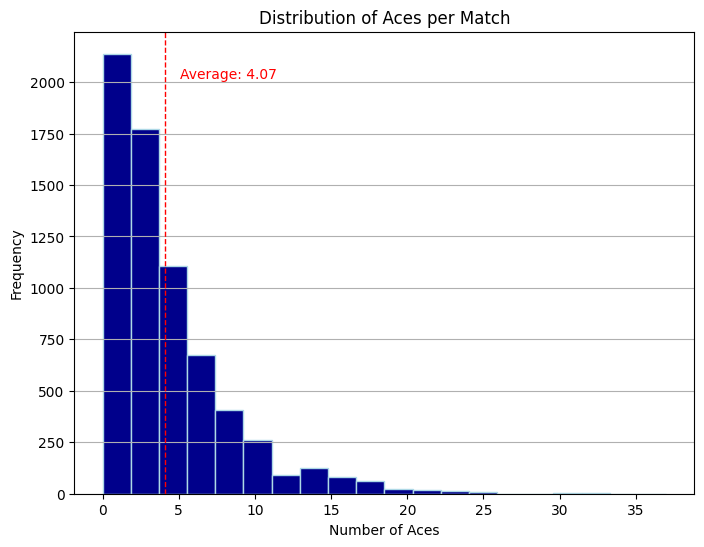

In [101]:
# Filter for aces data for the entire match
aces_data = statistics[(statistics['period'] == 'ALL') & (statistics['statistic_name']=='aces')]
aces_data = aces_data.sort_values('Record_date').drop_duplicates(['match_id','period'],keep='last')

# Sum the aces for both home and away teams for each match
aces_data['total_aces']  = aces_data['home_stat'].astype(int) + aces_data['away_stat'].astype(int)
average_aces_per_match = aces_data['total_aces'].mean()
print(f"The average number of aces per match is: {average_aces_per_match:.2f}")

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(aces_data['total_aces'], bins=20, color='darkblue', edgecolor='lightblue')
plt.axvline(average_aces_per_match, color='red', linestyle='dashed', linewidth=1)
plt.text(average_aces_per_match + 1, plt.ylim()[1] * 0.9, f'Average: {average_aces_per_match:.2f}', color='red')
plt.xlabel('Number of Aces')
plt.ylabel('Frequency')
plt.title('Distribution of Aces per Match')
plt.grid(axis='y')

save_path = os.path.join(image_dir, '7.jpg')
plt.savefig(save_path)
plt.show()

8. Is there a difference in the number of double faults based on gender?

The average double faults by female is: 3.5929518907147098 and the average double faults by male is: 2.718599033816425


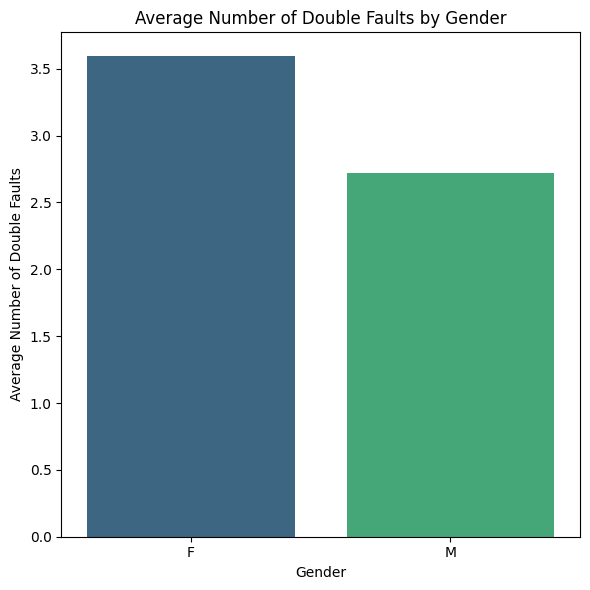

In [102]:
# Filter for double faults data for the entire match
double_faults_data=statistics[(statistics['period'] == 'ALL') & (statistics['statistic_name']=='double_faults')]
double_faults_data=double_faults_data.sort_values('Record_date').drop_duplicates(['match_id', 'period'],keep='last')


# Select relevant columns and rename them for merging
home_team_info = home_team[['match_id', 'gender']].drop_duplicates().rename(columns={'gender': 'home_gender'})
away_team_info = away_team[['match_id', 'gender']].drop_duplicates().rename(columns={'gender': 'away_gender'})

# Merge double_faults_data with home and away team info to get gender information
double_faults_with_gender = double_faults_data.merge(home_team_info, on='match_id', how='inner').merge(away_team_info, on='match_id', how='inner')

# Separate home and away double faults and rename them for concatenation
home_double_faults = double_faults_with_gender[['home_gender', 'home_stat']].rename(columns={'home_gender': 'gender', 'home_stat': 'double_faults'})
away_double_faults = double_faults_with_gender[['away_gender', 'away_stat']].rename(columns={'away_gender': 'gender', 'away_stat': 'double_faults'})

# Combine home and away double faults into one DataFrame
all_double_faults = pd.concat([home_double_faults, away_double_faults]).dropna()

# Convert double_faults to numeric
all_double_faults['double_faults'] = pd.to_numeric(all_double_faults['double_faults'], errors='coerce')

# Calculate the average number of double faults by gender
average_double_faults_by_gender = all_double_faults.groupby('gender')['double_faults'].mean().reset_index()
print(f"The average double faults by female is: {average_double_faults_by_gender.loc[0, 'double_faults']} and the average double faults by male is: {average_double_faults_by_gender.loc[1, 'double_faults']}")

# Plotting
plt.figure(figsize=(6, 6))
sns.barplot(data=average_double_faults_by_gender, x='gender', y='double_faults', hue='gender', palette='viridis', dodge=False, legend=False)
plt.title('Average Number of Double Faults by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Number of Double Faults')
plt.tight_layout()
save_path = os.path.join(image_dir, '8.jpg')
plt.savefig(save_path)
plt.show()


9. Which player has won the most tournaments in a single month?

In [103]:
# Merge all_winners with tournament info to get tournament
tournament_winners=all_winners.merge(tournament[['match_id','tournament_id']],on='match_id', how='inner').drop_duplicates()
tournament_wins=tournament_winners[['player_id','full_name']].value_counts().reset_index(name='win_count')

# Find the player with the highest number of wins in current month
most_tournament_wins = tournament_wins.sort_values(by='win_count', ascending=False).iloc[0]
print(f"The player with the highest number of tournament wins in May is {most_tournament_wins['full_name']} (ID: {most_tournament_wins['player_id']}) with {most_tournament_wins['win_count']} wins.")

The player with the highest number of tournament wins in May is Uchijima, Moyuka (ID: 253356) with 15 wins.


10. Is there a correlation between a player's height and their ranking?

The correlation between player height and their ranking is: 0.09


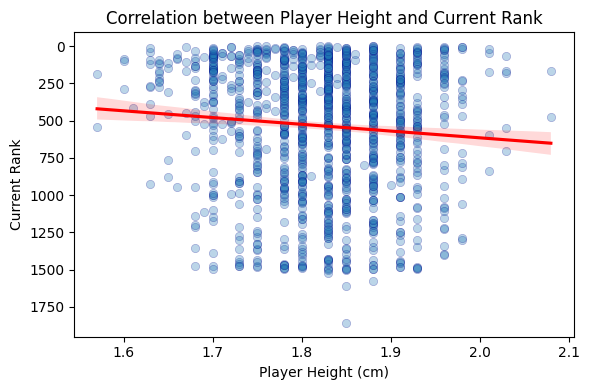

In [9]:
# Combine home and away team info to get player dataset
player_info = pd.concat([home_team, away_team]).sort_values('Record_date').drop_duplicates(['player_id'],keep='last')

# Select relevant columns
player_height_ranking = player_info[['player_id', 'height', 'current_rank']]

# Drop rows with missing values in 'height' or 'current_rank'
player_height_ranking = player_height_ranking.dropna(subset=['height', 'current_rank'])

# Calculate the correlation
correlation = player_height_ranking['height'].corr(player_height_ranking['current_rank'])
print(f'The correlation between player height and their ranking is: {correlation:.2f}')

# Plot the data
plt.figure(figsize=(6, 4))
sns.scatterplot(data=player_height_ranking, x='height', y='current_rank', alpha=0.3, edgecolor='darkblue')
sns.regplot(data=player_height_ranking, x='height', y='current_rank', scatter=False, color='red')
plt.xlabel('Player Height (cm)')
plt.ylabel('Current Rank')
plt.title('Correlation between Player Height and Current Rank')
plt.gca().invert_yaxis()  # Invert y-axis to show lower ranks (higher rankings) at the top
plt.tight_layout()
save_path = os.path.join(image_dir, '10.jpg')
plt.savefig(save_path)
plt.show()

11. What is the average duration of matches?

In [105]:
# Calculate the average duration
average_duration = time[time['total_duration'] > 0].sort_values('Record_date').drop_duplicates(['match_id'],keep='last')['total_duration'].mean()
print(f'The average duration of matches is: {average_duration/60:.2f} minutes')

The average duration of matches is: 124.25 minutes


12. What is the average number of games per set in men's matches compared to women's matches?

The average number of games per set in men's matches is 9.22.
The average number of games per set in women's matches is 8.93.


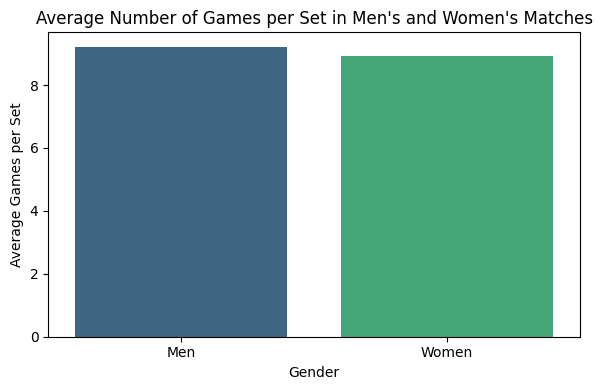

In [107]:
match_gender_info=pd.concat([home_team[['match_id','gender']],away_team[['match_id','gender']]]).drop_duplicates()

unique_pbp=pbp.sort_values('Record_date').drop_duplicates(['match_id','set_id','game_id'],keep='last')
games_per_set = unique_pbp.groupby(['match_id','set_id'])['game_id'].nunique().reset_index(name='game_count')
games_per_set_with_gender  = pd.merge(games_per_set, match_gender_info, on='match_id')

average_games_men = games_per_set_with_gender[games_per_set_with_gender['gender'] == 'M']['game_count'].mean()
average_games_women = games_per_set_with_gender[games_per_set_with_gender['gender'] == 'F']['game_count'].mean()

print(f"The average number of games per set in men's matches is {average_games_men:.2f}.")
print(f"The average number of games per set in women's matches is {average_games_women:.2f}.")

# Create a DataFrame for plotting
average_games_data = pd.DataFrame({
    'Gender': ['Men', 'Women'],
    'Average Games per Set': [average_games_men, average_games_women]
})

# Plot the data
plt.figure(figsize=(6, 4))
sns.barplot(x='Gender', y='Average Games per Set',hue='Gender', data=average_games_data, palette='viridis', dodge=False, legend=False)
plt.xlabel('Gender')
plt.ylabel('Average Games per Set')
plt.title('Average Number of Games per Set in Men\'s and Women\'s Matches')
plt.tight_layout()
save_path = os.path.join(image_dir, '12.jpg')
plt.savefig(save_path)
plt.show()

13. What is the distribution of left-handed versus right-handed players?

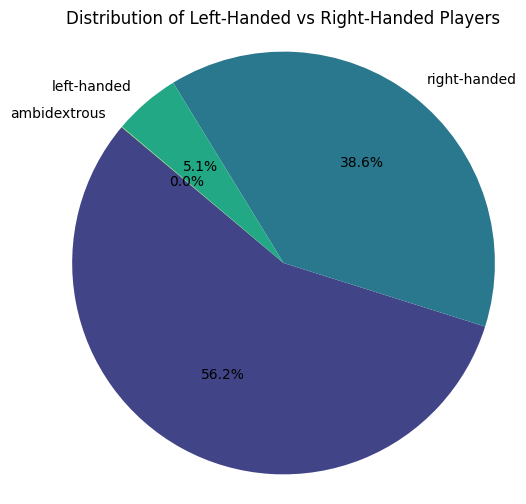

In [108]:
# Combine both home and away team data to analyze the distribution of left vs right-handed players
df_combined =pd.concat([home_team[['player_id','plays']],away_team[['player_id','plays']]]).drop_duplicates()

# Calculate the distribution
distribution = df_combined['plays'].value_counts(dropna=False).reset_index()
distribution.columns = ['handedness', 'count']
distribution

# Plotting the distribution using a pie chart
plt.figure(figsize=(6, 6))
plt.pie(distribution['count'], labels=distribution['handedness'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(distribution)))
plt.title('Distribution of Left-Handed vs Right-Handed Players')
plt.axis('equal')
save_path = os.path.join(image_dir, '13.jpg')
plt.savefig(save_path)
plt.show()

14. What is the most common type of surface used in tournaments?

The most common type of surface used in tournaments is: Red clay


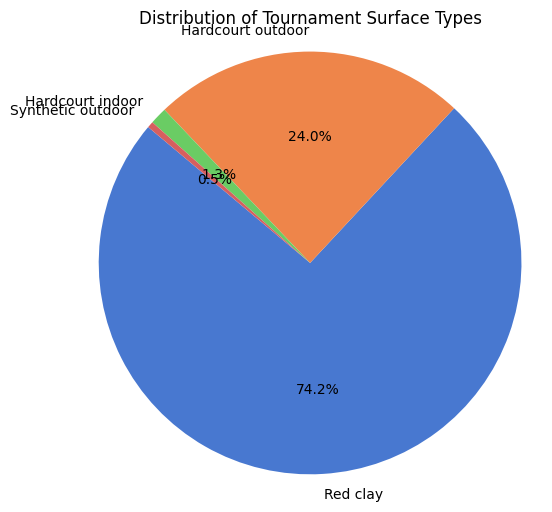

In [110]:
last_tournament=tournament.sort_values('Record_date').drop_duplicates(['match_id'],keep='last')
highest_ground_type=last_tournament['ground_type'].value_counts().idxmax()
print(f"The most common type of surface used in tournaments is: {highest_ground_type}")

surface_distribution = tournament['ground_type'].value_counts().reset_index()
surface_distribution.columns = ['surface_type', 'count']

# Plotting the distribution using a pie chart
plt.figure(figsize=(6, 6))
plt.pie(surface_distribution['count'], labels=surface_distribution['surface_type'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('muted', len(surface_distribution)))
plt.title('Distribution of Tournament Surface Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

15. How many distinct countries are represented in the dataset?

In [111]:
# Extract country columns
home_country = home_team['country']
away_country = away_team['country']
venue_contry=venue['country']


# Combine and count unique country
all_country = pd.concat([home_country, away_country,venue_contry])
unique_country = all_country.nunique()
print(f'The number of unique countries in the dataset is: {unique_country}')

The number of unique countries in the dataset is: 99


16. Which player has the highest winning percentage against top 10 ranked opponents?

The player with the highest winning percentage against top 10 ranked opponents is Dimitrov, Grigor with 100.00% wins.


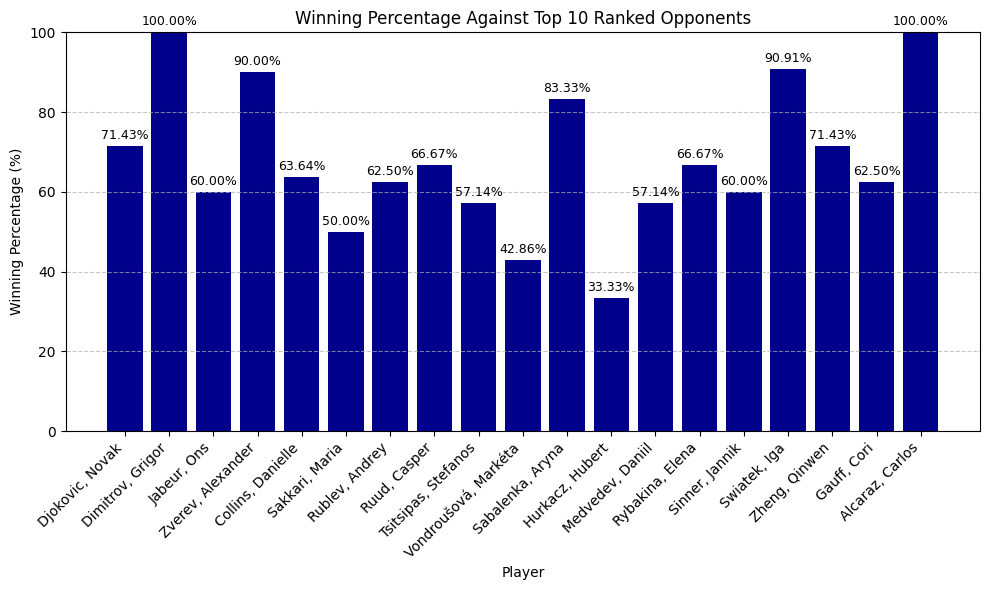

In [112]:
opponents = pd.concat([home_team[['player_id','current_rank','Record_date']],away_team[['player_id','current_rank','Record_date']]])
opponents=opponents.sort_values('Record_date').drop_duplicates(['player_id'],keep='last')
top_10_opponents= opponents[(opponents['current_rank'] <= 10)]

match_player_ids=pd.concat([home_team[['match_id','player_id']],away_team[['match_id','player_id']]]).drop_duplicates()
top_10_matches=match_player_ids.merge(top_10_opponents,on='player_id', how='inner')


# Merge to get winning matches
top_10_winning_matches = top_10_matches.merge(all_winners, on=['match_id', 'player_id'], how='left', indicator=True)
top_10_winning_matches

# Calculate wins and total matches
top_10_winning_matches['win'] = (top_10_winning_matches['_merge'] == 'both').astype(int)
top_10_winning_matches['total_matches'] = 1


# Step 3: Calculate Winning Percentage
winning_stats = top_10_winning_matches.groupby('player_id').agg({'win': 'sum', 'total_matches': 'sum'}).reset_index()
winning_stats['winning_percentage'] = winning_stats['win'] / winning_stats['total_matches'] * 100
winning_stats

# Get player names
player_names = pd.concat([home_team[['player_id', 'full_name']], away_team[['player_id', 'full_name']]]).drop_duplicates()
winning_stats = winning_stats.merge(player_names, on='player_id', how='inner')

# Find player with highest winning percentage
top_player = winning_stats.loc[winning_stats['winning_percentage'].idxmax()]

print(f'The player with the highest winning percentage against top 10 ranked opponents is {top_player["full_name"]} with {top_player["winning_percentage"]:.2f}% wins.')

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(winning_stats['full_name'], winning_stats['winning_percentage'], color='darkblue')
plt.xlabel('Player')
plt.ylabel('Winning Percentage (%)')
plt.title('Winning Percentage Against Top 10 Ranked Opponents')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)  # Optional: Set appropriate y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars with percentages
for i, v in enumerate(winning_stats['winning_percentage']):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontsize=9)

save_path = os.path.join(image_dir, '16.jpg')
plt.savefig(save_path)
plt.show()

17. What is the average number of breaks of serve per match?

In [113]:
# Filter the statistics for break points converted
breaks_stats = statistics[(statistics['period'] == 'ALL') & (statistics['statistic_name'] == 'break_points_converted')]
breaks_stats = breaks_stats.sort_values('Record_date').drop_duplicates(['match_id','period'],keep='last')


# Ensure home_stat and away_stat are numeric
breaks_stats['home_stat'] = pd.to_numeric(breaks_stats['home_stat'], errors='coerce')
breaks_stats['away_stat'] = pd.to_numeric(breaks_stats['away_stat'], errors='coerce')

# Sum the breaks for both home and away teams for each match
breaks_stats['total_breaks'] = breaks_stats['home_stat'] + breaks_stats['away_stat']

# Calculate the average number of breaks per match
average_breaks_per_match = breaks_stats['total_breaks'].mean()

print(f"The average number of breaks of serve per match is: {average_breaks_per_match:.2f}")

The average number of breaks of serve per match is: 7.29
